# Topic Modeling my iMessage conversations

In this notebook, I'll be building a topic model using messages I've sent in the past year. I collected this data by downloading the data from `chat.db`. I followed Dan Kelch's [helpful tutorial](https://spin.atomicobject.com/2020/05/22/search-imessage-sql/) to get access to the `chat.db` and then used the code in `collect_imessage_data.py` (found in the src folder) to export each table as a csv.

I'll be using the `message` table in this analysis, since it's the table that contains all the messages I've sent and recieved, along with interesting metadata. I'll only be using my messages, and any messages sent to me from others will be excluded to maintain their privacy.

In [2]:
import pandas as pd
import html

In [3]:
data = pd.read_csv("../data/raw/message.csv", low_memory=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11889 entries, 0 to 11888
Data columns (total 74 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ROWID                              11889 non-null  int64  
 1   guid                               11889 non-null  object 
 2   text                               11486 non-null  object 
 3   replace                            11889 non-null  int64  
 4   service_center                     0 non-null      float64
 5   handle_id                          11889 non-null  int64  
 6   subject                            4 non-null      object 
 7   country                            0 non-null      float64
 8   attributedBody                     11486 non-null  object 
 9   version                            11889 non-null  int64  
 10  type                               11889 non-null  int64  
 11  service                            11889 non-null  obj

In [14]:
from urllib.parse import urlparse

In [38]:
data['text'] = data['text'].astype(str).apply(lambda x: ' '.join([urlparse(_)[1] if urlparse(_)[1] != '' else _ for _ in x.split()]))

In [39]:
text = data.query('is_from_me == 1')['text'].apply(html.unescape).values
text

array(['Argh, that’d be fun but we’re going to Nashville to see our niece this weekend',
       'Maybe next weekend? OOO or if you and chris are down we can try to rent some Kayaks?',
       '￼', ..., 'Yeah gimme 15', 'Getting on',
       'Good! Uneventful LOL how’s yours?'], dtype=object)

In [40]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text, show_progress_bar=True)

Batches:   0%|          | 0/136 [00:00<?, ?it/s]

Now I have a set of document embeddings I could work with, but they're huge vectors, each of length 768. Knowing that, and recognizing that I'm working on my Macbook air and don't have grand resources to model with, I'm going to perform some dimensionality reduction on these embeddings.

There are many different techniques, but today I'm going ot use UMAP.

### UMAP

UMAP stands for Uniform Manifold Approximation and Projection. This is a neighbor-based dimensionality reduction technique like t-SNE, as opposed to a matrix factorization technique like Principal Component Analysis (PCA).

In essence UMAP first builds a connected graph between all the data points by find the k-nearest neighbors for each point within some distance metrics $d$. The specifics of this connection processes makes UMAP discint (and arguable better) than its competitor t-SNE; UMAP uses a unique k-NN descent algorithm that ensures each point in the graph is connected to at least one other point with an edge weight of 1.

Once the data points are connected, UMAP forces the data into a low dimensional space (usually two or three dimensions). In this process, the weights between the points of the projected or low dimension graph are compared to the wieghts on the original graph. UMAP attempts to approximate these two set of weights using edge-wise cross entropy. This ensures that the low dimensionality graph is as close to the high dimension graph as possible.

You can review the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html), read the author's publication [UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction](https://arxiv.org/pdf/1802.03426.pdf)(warning: it's 63 pages!), watch the author's [SciPy 2018 presentation](https://www.youtube.com/watch?v=nq6iPZVUxZU), or [watch my favorite explination of it](https://www.youtube.com/watch?v=6BPl81wGGP8) to get a deep understanding of it.

In [13]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=10, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [14]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

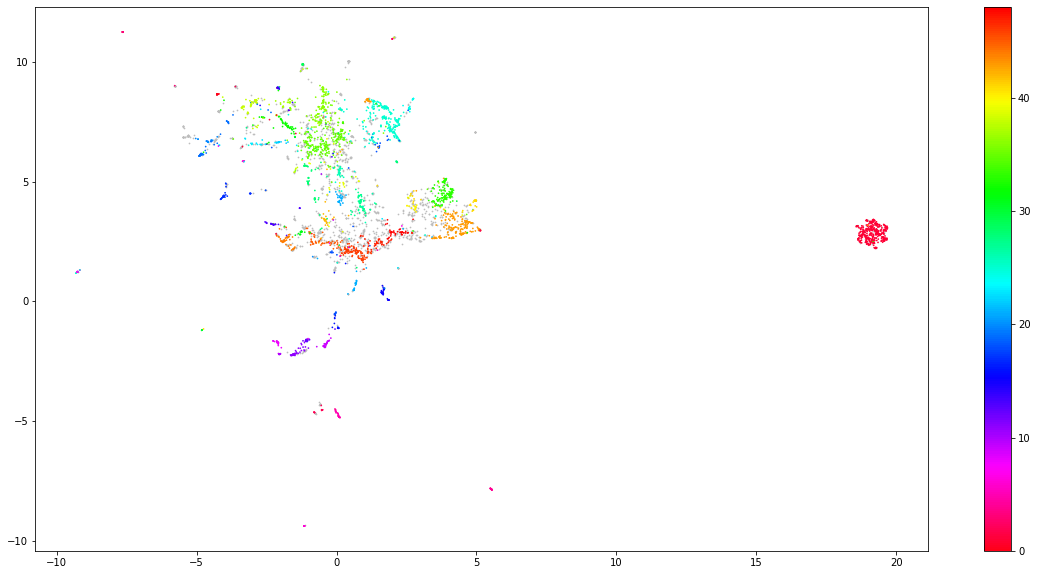

In [16]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

In [216]:
for c in set(cluster.labels_):
    if c == -1:
        continue
    top_idx = exemplars = [np.where(np.all(umap_embeddings == cluster.exemplars_[c][i], axis=1) == True)[0][0] for i in range(5)]
    print("Representative messages for cluster {}".format(c))
    print('=====================================')
    for idx in top_idx:
        print(text[idx])
    print('\n')

Representative messages for cluster 0
￼
￼
￼
￼GTFO
￼


Representative messages for cluster 1
https://twitter.com/deafbeatdad/status/1299441304552779778?s=20
https://twitter.com/miakhalifa/status/1354518139615109121?s=20
https://twitter.com/0cks/status/1300952493610987520?s=20
https://twitter.com/deafbeatdad/status/1299441304552779778?s=20
https://twitter.com/StarrburyMike/status/1354444455886118915?s=20


Representative messages for cluster 2
Pex?
Pex?
Pex?
Pex?
Pex?


Representative messages for cluster 3
https://www.youtube.com/watch?v=UWNDLaAYBrQ
https://m.youtube.com/watch?v=v6P8QmDS0Q4
https://www.youtube.com/watch?v=zxC-UkdEI5E
https://m.youtube.com/watch?v=hx1mjT73xYE
https://www.youtube.com/watch?v=Sg7ZHGX0td4


Representative messages for cluster 4
https://www.npr.org/series/967404527/planet-money-buys-a-superhero
https://www.airbnb.com/rooms/43077205?location=Maryland&check_in=2020-09-11&check_out=2020-09-22&source_impression_id=p3_1597259261_5VANqo7mVtWweytO
https://www.airbn

In [21]:
label_df = pd.DataFrame({
    'message':text,
    'cluster':cluster.labels_
})
label_df.head()

,message,cluster
0,"Argh, that’d be fun but we’re going to Nashvil...",18
1,Maybe next weekend? OOO or if you and chris ar...,-1
2,￼,1
3,https://open.spotify.com/track/3nS9a01VvXHQriL...,11
4,I’m down gimme 10,31


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [26]:
class_messages = label_df.groupby('cluster').agg({'message': ' '.join})['message'].values

In [41]:
vectorizer = TfidfVectorizer().fit(class_messages)
vectorized_messages = vectorizer.transform(class_messages).toarray()
words = vectorizer.get_feature_names()

In [53]:
pd.DataFrame({c:[words[index] for index in vectorized_messages[c].argsort()[::-1][:5]] for c in set(cluster.labels_)})

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,-1
0,the,lol,gtfo,twitter,pex,watch,status,image,image,https,...,later,died,down,tomorrow,not,30,00,to,to,the
1,to,lololol,marriage,status,welfare,youtube,twitter,laughed,loved,com,...,that,the,only,new,no,like,to,we,the,they
2,you,pew,backl,https,ubi,https,20,lit,an,www,...,the,crashed,the,to,don,45,we,the,of,and
3,it,double,triggered,com,either,com,https,an,great,org,...,on,shinsky,im,you,never,200,the,you,and,that
4,and,nah,also,kathygriffin,or,www,com,at,after,calculator,...,can,lost,lame,fund,to,maybe,hour,and,it,of
